In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [3]:
df = pd.read_hdf('Giant.h5')


In [4]:
df.head(10)

,x,y,theta,tail_angle_01,tail_angle_02,tail_angle_03,tail_angle_04,tail_angle_05,tail_angle_06,tail_angle_07,...,tail_value_01,tail_value_02,tail_value_03,tail_value_04,tail_value_05,tail_value_06,tail_value_07,tail_value_08,tail_value_09,tail_value_10
frame_id,,,,,,,,,,,,,,,,,,,,,
103601,73.69724,595.5804,1.661527,0.050498,-0.016440,0.009068,-0.012574,-0.019070,0.046330,-0.007306,...,558.2509,294.4854,235.4711,203.8689,183.4497,137.1873,115.1374,83.65917,86.44755,30.16367
103602,73.72903,595.6200,1.660250,0.043642,0.001564,0.002408,-0.029698,0.011411,0.021807,-0.001874,...,563.1628,287.7928,238.8775,202.2527,184.4944,136.7738,116.4228,81.63942,81.31573,28.75116
103603,73.68596,595.6003,1.663265,0.041430,-0.004075,0.002937,-0.022274,0.012015,0.014713,0.002269,...,564.0679,286.3506,237.1006,198.0228,182.5386,136.2459,113.4250,83.32574,81.35854,24.85457
103604,73.71770,595.6288,1.661963,0.042159,-0.004702,0.005740,-0.015064,-0.014538,0.037468,-0.002097,...,558.5044,286.6552,232.8338,192.9184,187.4003,139.3187,112.5696,84.12813,82.79957,25.64803
103605,73.71770,595.6288,1.661723,0.040063,-0.000466,0.004081,-0.025827,0.005307,0.033360,-0.001918,...,553.3157,285.1667,238.9282,201.0047,187.9429,137.3472,111.8874,81.48780,81.23280,28.09221
103606,73.74426,595.6652,1.660766,0.042486,-0.003265,0.004266,-0.025068,0.004170,0.036396,-0.009972,...,552.2186,285.6654,234.5071,198.6155,188.8189,141.5963,111.5304,87.59415,80.97386,24.69491
103607,73.71761,595.8105,1.661348,0.040919,0.005434,-0.009359,-0.012313,-0.004558,0.030436,-0.001653,...,572.7526,288.1426,227.6399,196.9709,194.3045,143.0983,114.4926,84.29243,84.90253,21.90531
103608,73.74799,595.7083,1.660955,0.043138,-0.005130,0.008116,-0.023209,-0.006627,0.038300,-0.008463,...,561.8183,288.2664,233.3537,196.2758,187.9764,143.5434,110.4618,82.25309,76.15679,27.13316
103609,73.74596,595.6342,1.660619,0.046214,-0.007942,0.004954,-0.030293,0.021400,0.015620,-0.005273,...,546.4205,281.3492,235.9477,200.4252,189.7549,140.3379,106.6939,82.59312,75.60749,25.16049


In [5]:

def tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=400,MaxFiltSize=20,margin_std=2):
    """ Runs data processing scripts to turn raw data from (../raw) into
        cleaned data ready to be analyzed (saved in ../processed).
    """
    # Smooth Tail angle and compute measure of intensity
    cumul_tail_angle,smooth_cumul_tail_angle,notrack = compute_smooth_tail_angle(tail_angle)
    smooth_tail_speed,speed_tail_angle,super_cumul = compute_tail_speed(smooth_cumul_tail_angle,notrack,NumSegments,BCFilt)
    
    # MinFilt remove unstable baseline & MaxFilt merge bouts
    low_pass_tail_speed,max_filt,min_filt = mexican_hat_tail_speed(smooth_tail_speed,MinFiltSize,MaxFiltSize)
    
    # Compute threshold based on FWHM of speed distribution
    BoutThresh = estimate_speed_threshold(low_pass_tail_speed+1e-6, margin_std,bin_log_min = -5, bin_log_max=5)
    
    # Compute Speed:
    tail_angle_speed = np.zeros_like(smooth_cumul_tail_angle)

    for s in range(tail_angle_speed.shape[1]):
        print(s)
        tail_angle_speed[:,s] = diff_but_better(smooth_cumul_tail_angle[:,s],dt=1/700, filter_length=71)
    
    return smooth_cumul_tail_angle,low_pass_tail_speed,BoutThresh,tail_angle_speed,notrack

In [6]:
def main_segmentation(all_bout_f,tail_angle,tail_angle_speed,Min_Duration = 80,Min_IBI = 10,MinInterPeakDistance = 7,MaxLookahead=5,MaxPercentage=0.3,DiscontinuityPercentage=0.4,StartingIBI=5,NoiseThresh=2):
    

    # Compute Running Average to compute bouts amplitude:
    BCFilt = 50
    ds_ = pd.Series(tail_angle)
    running_avg_tail = ds_.rolling(BCFilt,center=False).mean().values
    detrended_tail_angle= (tail_angle-running_avg_tail)*all_bout_f

    # Find when tail is active:
    onset,offset,duration = find_onset_offset_numpy(all_bout_f==1)
    
    # Refine Segmentation:
    onset_guess, offset_guess, duration, inter_bouts = refine_segmentation_bouts(onset, offset, Min_Duration, Min_IBI)
    onset_guess, offset_guess = onset_guess.tolist(),offset_guess.tolist()
    # Loop over bouts:
    onset,offset = [],[]

    while len(onset_guess)>0:
        #print(len(onset))
        on_ = onset_guess.pop(0)
        off_ = offset_guess.pop(0)
        dur_ = off_-on_
        
        peaks_pos,peaks_neg = find_zeros_crossing(tail_angle_speed[on_:off_])

        # Is there at least an oscillation:
        if is_there_oscillation(peaks_pos,peaks_neg):

            # If two consecutive peaks are closer than <distance> we remove the location corresponding to the smallest value
            peaks_pos = clean_peak_forcing_distance(peaks_pos,tail_angle[on_:off_],Distance=MinInterPeakDistance,sign=1)
            peaks_neg = clean_peak_forcing_distance(peaks_neg,tail_angle[on_:off_],Distance=MinInterPeakDistance,sign=-1)

            # Make Sure all peaks are alternating
            peaks_pos,peaks_neg = clean_peak_forcing_alternation(peaks_pos,peaks_neg,tail_angle[on_:off_])
            # Find the first peak of the bouts (first larger than <percentage> of largest value)
            all_peak = interleave(peaks_pos,peaks_neg)
            
            amplitude = [np.abs(detrended_tail_angle[on_:off_][p]) for p in all_peak]
            #amplitude = [tail_angle[on_:off_][f]-tail_angle[on_:off_][l] for l,f in zip(all_peak[:-1],all_peak[1:])]
            ThreshOnset = MaxPercentage*np.max(np.abs(amplitude[:MaxLookahead]))
            #first_peak_loc = all_peak[1+np.argmax(np.abs(amplitude)>ThreshOnset)]
            first_peak_loc = all_peak[np.argmax(np.abs(amplitude)>ThreshOnset)]
            
            # Remove peak before onset:
            peaks_pos = peaks_pos[peaks_pos>=first_peak_loc]
            peaks_neg = peaks_neg[peaks_neg>=first_peak_loc]
            
            ### Look for abrupt change in periodicity or amplitude
            # Find When Peak to Peak Amplitude 
            if is_there_oscillation(peaks_pos,peaks_neg):
                    
                all_peak = interleave(peaks_pos,peaks_neg)
                
                
                break_in_amplitude,cut = is_break_in_amplitude(tail_angle[on_:off_],all_peak,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)

                if break_in_amplitude:
                    peaks_pos = peaks_pos[peaks_pos<=cut]
                    peaks_neg = peaks_neg[peaks_neg<=cut]

                # Check Discontinuity in interbeat interval:
                break_in_ibi_pos,cut_pos = is_break_in_interbeatinterval(peaks_pos,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)
                break_in_ibi_neg,cut_neg = is_break_in_interbeatinterval(peaks_neg,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)
                if break_in_ibi_pos:
                    peaks_pos = peaks_pos[peaks_pos<cut_pos]
                    peaks_neg = peaks_neg[peaks_neg<cut_pos]
                if break_in_ibi_neg:
                    peaks_pos = peaks_pos[peaks_pos<cut_neg]
                    peaks_neg = peaks_neg[peaks_neg<cut_neg]

                # Split bout'''
                peaks_pos = peaks_pos.tolist()
                peaks_neg = peaks_neg.tolist()
                
             
                # Define Onset and Offset:
                onset.append(on_+min(peaks_pos+peaks_neg))#+ min(peaks_pos+peaks_neg)
                Bout_Duration_FromFirstPeak = max(peaks_pos+peaks_neg) - min(peaks_pos+peaks_neg)
                offset.append(onset[-1]  + max(Min_Duration,Bout_Duration_FromFirstPeak))
                                
                # Is there room for a double bout:
                if (off_ - offset[-1]-5)>Min_Duration:
                    # Introduce New Bouts
                    onset_guess.insert(0,offset[-1]+5) # Introduce a margin between bouts
                    offset_guess.insert(0,off_)
    # Make sure this is not just noise:
    onset_guess,offset_guess = onset,offset
    onset,offset = [],[]
    for on_,off_ in zip(onset_guess,offset_guess):
        if is_there_signal(tail_angle[on_:off_],Thresh=NoiseThresh):
            onset.append(on_)
            offset.append(off_)
            
    return onset,offset


In [7]:
# use tail value as a mask:
tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,11)]]
tail_angle = tail_angle.values


In [39]:
from utils.utils_bouts import diff_but_better,compute_smooth_tail_angle,compute_tail_speed,mexican_hat_tail_speed,estimate_speed_threshold,find_onset_offset_numpy
from utils.utils_beat import refine_segmentation_bouts,find_zeros_crossing,is_there_oscillation,clean_peak_forcing_distance,clean_peak_forcing_alternation,interleave,is_break_in_amplitude,is_break_in_interbeatinterval,is_there_signal

In [17]:
smooth_cumul_tail_angle, low_pass_tail_speed, BoutThresh, tail_angle_speed, notrack = tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=400,MaxFiltSize=20,margin_std=2)

Shape of No Track:
(1828,)
0
1
2
3
4
5
6
7
8
9


In [40]:
# 
tail_active = (low_pass_tail_speed>BoutThresh)*1.0
ReferenceSegment=6

onset,offset = main_segmentation(tail_active,smooth_cumul_tail_angle[:,ReferenceSegment],tail_angle_speed[:,ReferenceSegment],Min_Duration = 200,Min_IBI = 10,MinInterPeakDistance = 7,MaxLookahead=10,MaxPercentage=0.3,DiscontinuityPercentage=0.3,StartingIBI=4)

duration = [off_-on_ for on_,off_ in zip(onset,offset)]
print(min(duration))


200


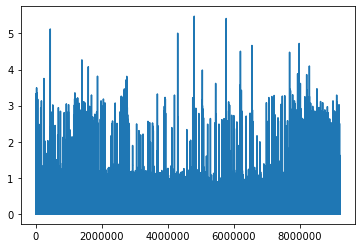

In [19]:
plt.plot(low_pass_tail_speed)

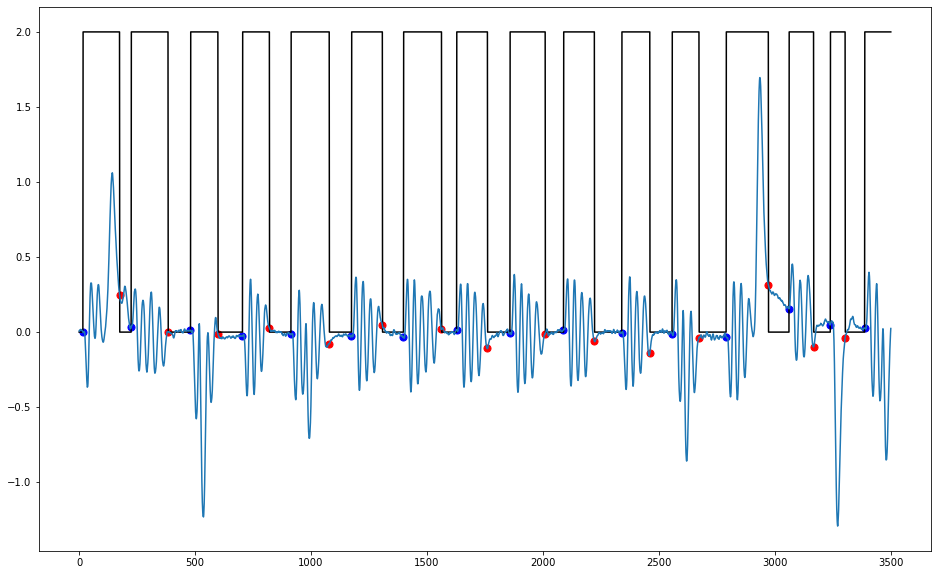

In [45]:
# Diagnostic Plot:
Duration = 700*5
IdSt = 700*60*5
#IdSt = np.random.randint(low_pass_tail_speed.shape[0]-Duration)

fig, (ax1) = plt.subplots(1,1,figsize=(16,10), sharex=True)

ax1.plot(tail_active[IdSt:IdSt+Duration]*2,'k')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
if len(id)>0:
    ax1.scatter(id,smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='b')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
if len(id)>0:
    ax1.scatter(id,smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='r')
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment])
plt.show()

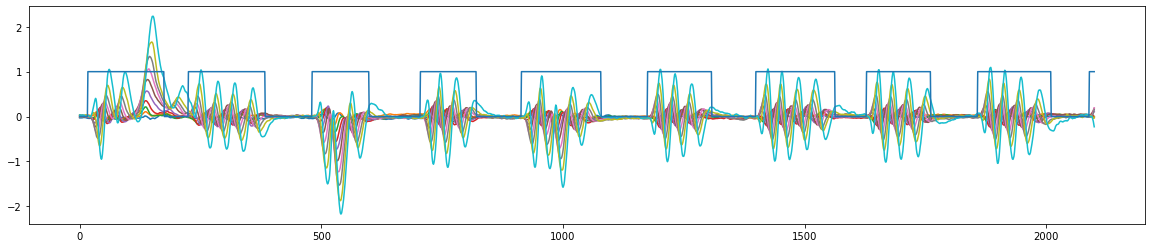

In [44]:
IdSt = 700*60*5
Duration = 700*3
plt.figure(figsize=(20,4))
plt.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])
plt.plot(tail_active[IdSt:IdSt+Duration])